In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 22})

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [50]:
indices = es.cat.indices(index="rucio-events*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
#print(indices)

In [51]:
_src = 'CERN-PROD*'
_dst = 'BNL*'

In [64]:
queryBytes30= {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-submitted",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": 'now-30d',
                  "lte": 'now',
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "@timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 'now-30d',
          "max": 'now'
        }
      },
      "aggs": {
        "3": {
          "sum": {
            "field": "payload.bytes"
          }
        }
      }
    }
  }
}
bytes30 = es.search(index="rucio-events*", body=queryBytes30, request_timeout=600)

In [73]:
queryDuration30 = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": 'now-30d',
                  "lte": 'now',
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "@timestamp",
        "interval": "1d",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 'now-30d',
          "max": 'now'
        }
      },
      "aggs": {
        "3": {
          "sum": {
            "field": "payload.duration"
          }
        }
      }
    }
  }
}
duration30 = es.search(index="rucio-events*", body=queryDuration30, request_timeout=600)

In [74]:
def getThing(res):
    bytesize = []
    times = []
    for r in res['aggregations']['2']['buckets']:
        bytesize.append(r['3']['value'])
        times.append(r['key'])
    times = np.array(times)
    bytesize = np.array(bytesize)
    return times,bytesize


In [75]:
bytesizeTime30,bytesize30 = getThing(bytes30)
durationTime30, duration30 = getThing(duration30)

throughput = byteSize30/duration30
throughput.shape


(31,)

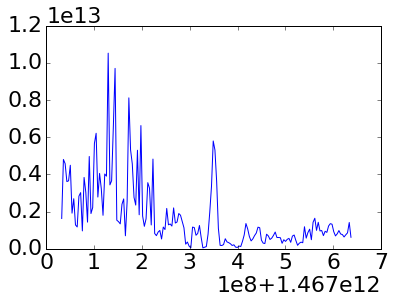